<a href="https://colab.research.google.com/github/shuvo8220/Task1-Credit-Scoring-Mode/blob/main/Task1_Credit_Scoring_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports & Constants

In [ ]:
# Imports
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.inspection import permutation_importance

# Constants
RANDOM_STATE = 42
ARTIFACT_DIR = "./credit_model_artifacts"


In [ ]:
import os

os.makedirs("./credit_model_artifacts", exist_ok=True)


Data Generation

In [ ]:
def generate_synthetic_credit_data(n=1500, seed=RANDOM_STATE):
    rng = np.random.RandomState(seed)
    income = rng.normal(45000, 20000, size=n).clip(5000, 300000)
    total_debt = rng.normal(15000, 12000, size=n).clip(0, 200000)
    credit_utilization = rng.beta(2, 5, size=n)
    num_credit_lines = rng.poisson(4, size=n).clip(1, 30)
    num_late_payments = rng.poisson(1.2, size=n)
    percent_on_time = (1 - (num_late_payments / (num_credit_lines + 1))).clip(0, 1)
    age_of_credit_history = rng.normal(7, 4, size=n).clip(0.5, 50)
    num_previous_defaults = rng.binomial(1, 0.05, size=n)
    employment_length = rng.normal(5, 3, size=n).clip(0, 40)
    employment_type = rng.choice(['salaried', 'self-employed', 'unemployed', 'student'],
                                 size=n, p=[0.6, 0.25, 0.1, 0.05])
    home_ownership = rng.choice(['mortgage', 'rent', 'own', 'other'],
                                size=n, p=[0.45, 0.4, 0.12, 0.03])

    risk_score = (
        0.00003 * income
        - 0.00005 * total_debt
        - 2.0 * credit_utilization
        + 0.02 * percent_on_time * 100
        + 0.03 * age_of_credit_history
        - 0.5 * num_previous_defaults
        + 0.01 * employment_length
        + (employment_type == 'salaried') * 0.5
        - (employment_type == 'unemployed') * 1.0
    )
    prob = 1 / (1 + np.exp(-risk_score))
    creditworthy = rng.binomial(1, prob)

    df = pd.DataFrame({
        'income': income,
        'total_debt': total_debt,
        'credit_utilization': credit_utilization,
        'num_credit_lines': num_credit_lines,
        'num_late_payments': num_late_payments,
        'percent_on_time': percent_on_time,
        'age_of_credit_history': age_of_credit_history,
        'num_previous_defaults': num_previous_defaults,
        'employment_length': employment_length,
        'employment_type': employment_type,
        'home_ownership': home_ownership,
        'creditworthy': creditworthy
    })

    # small missingness
    for col in ['income', 'employment_length', 'employment_type']:
        mask = rng.rand(n) < 0.02
        df.loc[mask, col] = np.nan

    return df


Feature Engineering

In [ ]:
def add_features(df):
    df = df.copy()
    df['debt_to_income'] = (df['total_debt'] / (df['income'] + 1)).clip(0, 10)
    df['late_payment_rate'] = (df['num_late_payments'] / (df['num_credit_lines'] + 1)).clip(0, 1)
    return df


Preprocessor

In [ ]:
def build_preprocessor():
    numeric_features = [
        'income', 'total_debt', 'debt_to_income', 'credit_utilization', 'num_credit_lines',
        'num_late_payments', 'late_payment_rate', 'percent_on_time', 'age_of_credit_history',
        'num_previous_defaults', 'employment_length'
    ]
    categorical_features = ['employment_type', 'home_ownership']

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

    return preprocessor, numeric_features, categorical_features


Model Definitions

In [ ]:
def get_models(random_state=RANDOM_STATE):
    return {
        'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=random_state),
        'DecisionTree': DecisionTreeClassifier(class_weight='balanced', random_state=random_state),
        'RandomForest': RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=random_state)
    }


Training & Evaluation

In [ ]:
def train_models(X_train, y_train, X_test, y_test, preprocessor, models_dict):
    trained = {}
    aucs = {}
    probas = {}

    for name, model in models_dict.items():
        pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
        pipe.fit(X_train, y_train)

        y_pred = pipe.predict(X_test)
        y_proba = pipe.predict_proba(X_test)[:, 1]

        print(f"\n===== {name} =====")
        print(classification_report(y_test, y_pred))

        auc = roc_auc_score(y_test, y_proba)
        print("ROC-AUC:", auc)
        print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

        trained[name] = pipe
        aucs[name] = auc
        probas[name] = y_proba

    return trained, aucs, probas


RandomForest Tuning

In [ ]:
def tune_random_forest(X_train, y_train, preprocessor, cv_splits=3):
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 8],
    }
    rf_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE))
    ])

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE)
    search = GridSearchCV(rf_pipe, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
    search.fit(X_train, y_train)

    return search.best_estimator_, search.best_params_


ROC Curve Plot

In [ ]:
def plot_roc_curves(probas_dict, aucs_dict, y_test, show_plot=True, save_path=None):
    plt.figure(figsize=(8, 6))

    for name, y_proba in probas_dict.items():
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={aucs_dict[name]:.3f})")

    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC Curves")
    plt.legend(loc='lower right')
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    if show_plot:
        plt.show()
    plt.close()


Permutation Importance

In [ ]:
def permutation_importance_report(best_pipeline, X_test, y_test, numeric_features, categorical_features, n_repeats=3):
    X_test_transformed = best_pipeline.named_steps['preprocessor'].transform(X_test)
    r = permutation_importance(best_pipeline.named_steps['classifier'], X_test_transformed, y_test,
                               n_repeats=n_repeats, random_state=RANDOM_STATE, n_jobs=-1)
    ohe = best_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
    feature_names = numeric_features + ohe_feature_names
    perm_importances = pd.Series(r.importances_mean, index=feature_names).sort_values(ascending=False)
    return perm_importances



Save Artifacts

In [ ]:
def save_artifacts(trained_pipelines, df, artifact_dir=ARTIFACT_DIR):
    os.makedirs(artifact_dir, exist_ok=True)

    for name, pipe in trained_pipelines.items():
        path = os.path.join(artifact_dir, f"{name}_pipeline.joblib")
        joblib.dump(pipe, path)

    csv_path = os.path.join(artifact_dir, "full_synthetic_credit_dataset.csv")
    df.to_csv(csv_path, index=False)
    print(f"Saved artifacts to {artifact_dir}")


Main Orchestration

In [ ]:
def main():
    df = generate_synthetic_credit_data(n=1500)
    df = add_features(df)

    target = 'creditworthy'
    feature_cols = [
        'income', 'total_debt', 'debt_to_income', 'credit_utilization', 'num_credit_lines',
        'num_late_payments', 'late_payment_rate', 'percent_on_time', 'age_of_credit_history',
        'num_previous_defaults', 'employment_length', 'employment_type', 'home_ownership'
    ]

    X = df[feature_cols]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
    )

    preprocessor, numeric_features, categorical_features = build_preprocessor()
    models = get_models()

    trained, aucs, probas = train_models(X_train, y_train, X_test, y_test, preprocessor, models)

    best_rf, best_params = tune_random_forest(X_train, y_train, preprocessor, cv_splits=3)
    print("Best RF params:", best_params)

    best_rf_proba = best_rf.predict_proba(X_test)[:, 1]
    best_rf_auc = roc_auc_score(y_test, best_rf_proba)
    print("Best RF ROC-AUC on test:", best_rf_auc)

    trained['RandomForest_Tuned'] = best_rf
    aucs['RandomForest_Tuned'] = best_rf_auc
    probas['RandomForest_Tuned'] = best_rf_proba

    plot_roc_curves(probas, aucs, y_test, save_path=os.path.join(ARTIFACT_DIR, "roc_curves.png"))

    perm_importances = permutation_importance_report(best_rf, X_test, y_test, numeric_features, categorical_features, n_repeats=3)
    print("\nTop permutation importances:\n", perm_importances.head(15))

    save_artifacts(trained, df, artifact_dir=ARTIFACT_DIR)


Run the Pipeline


===== LogisticRegression =====
              precision    recall  f1-score   support

           0       0.32      0.56      0.41        52
           1       0.89      0.75      0.81       248

    accuracy                           0.72       300
   macro avg       0.60      0.65      0.61       300
weighted avg       0.79      0.72      0.74       300

ROC-AUC: 0.7424782878411911
Confusion matrix:
 [[ 29  23]
 [ 62 186]]

===== DecisionTree =====
              precision    recall  f1-score   support

           0       0.42      0.31      0.36        52
           1       0.86      0.91      0.89       248

    accuracy                           0.81       300
   macro avg       0.64      0.61      0.62       300
weighted avg       0.79      0.81      0.79       300

ROC-AUC: 0.6094913151364765
Confusion matrix:
 [[ 16  36]
 [ 22 226]]

===== RandomForest =====
              precision    recall  f1-score   support

           0       0.75      0.06      0.11        52
           1 

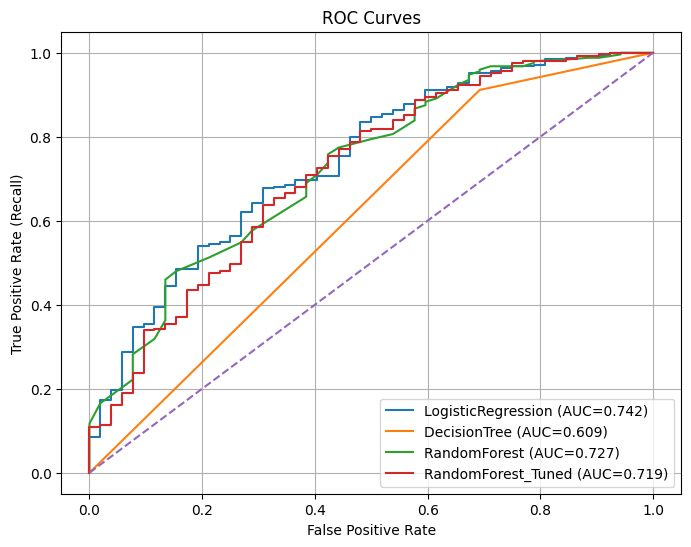


Top permutation importances:
 debt_to_income              0.014444
employment_length           0.012222
total_debt                  0.006667
num_credit_lines            0.006667
credit_utilization          0.006667
income                      0.005556
num_late_payments           0.003333
percent_on_time             0.003333
employment_type_salaried    0.002222
home_ownership_mortgage     0.001111
age_of_credit_history       0.001111
home_ownership_own          0.001111
employment_type_student     0.000000
home_ownership_rent         0.000000
late_payment_rate          -0.001111
dtype: float64
Saved artifacts to ./credit_model_artifacts


In [ ]:
if __name__ == "__main__":
    main()
